In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('App') \
    .getOrCreate()

rawData1 = spark.read \
    .format('csv') \
    .option('header', 'true') \
    .load('../datasets/wine/1.csv')

rawData2 = spark.read \
    .format('csv') \
    .option('header', 'true') \
    .load('../datasets/wine/2.csv')

In [2]:
dataset1 = rawData1.drop('region_1', 'region_2')

dataset1.toPandas().head()

,_c0,country,description,designation,points,price,province,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Provence red blend,Domaine de la Bégude


In [3]:
dataset2 = rawData2.drop('region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title')

dataset2.toPandas().head()

,_c0,country,description,designation,points,price,province,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,None,Sicily & Sardinia,White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [4]:
unionDF = dataset1.union(dataset2)

In [5]:
unionDF.toPandas().count()

_c0            280910
country        280842
description    280908
designation    197715
points         280895
price          258214
province       280833
variety        280892
winery         280881
dtype: int64

In [6]:
unionDF = unionDF.replace('?', None).dropna(how='any')

In [7]:
unionDF.toPandas().count()

_c0            181059
country        181059
description    181059
designation    181059
points         181059
price          181059
province       181059
variety        181059
winery         181059
dtype: int64

In [8]:
from pyspark.sql.functions import col

unionDF = unionDF.withColumnRenamed('_c0','id') \
    .withColumn('id',col('id').cast('int')) \
    .withColumn('points',col('points').cast('float')) \
    .withColumn('price',col('price').cast('float'))

In [9]:
unionDF.toPandas().head()

,id,country,description,designation,points,price,province,variety,winery
0,0.0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96.0,235.0,California,Cabernet Sauvignon,Heitz
1,1.0,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96.0,110.0,Northern Spain,Tinta de Toro,Bodega Carmen Rodríguez
2,2.0,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96.0,90.0,California,Sauvignon Blanc,Macauley
3,3.0,US,"This spent 20 months in 30% new French oak, an...",Reserve,96.0,65.0,Oregon,Pinot Noir,Ponzi
4,4.0,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95.0,66.0,Provence,Provence red blend,Domaine de la Bégude


In [10]:
from pyspark.ml.feature import RegexTokenizer, CountVectorizer

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="description", outputCol="words", pattern="\\W")

# bag of words count
countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

label_stringIdx = StringIndexer(inputCol = "variety", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(unionDF)
dataset = pipelineFit.transform(unionDF)
dataset.show(5)

+---+-------+--------------------+--------------------+------+-----+--------------+------------------+--------------------+--------------------+--------------------+-----+
| id|country|         description|         designation|points|price|      province|           variety|              winery|               words|            features|label|
+---+-------+--------------------+--------------------+------+-----+--------------+------------------+--------------------+--------------------+--------------------+-----+
|  0|     US|This tremendous 1...|   Martha's Vineyard|  96.0|235.0|    California|Cabernet Sauvignon|               Heitz|[this, tremendous...|(10000,[0,1,2,3,5...|  3.0|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|  96.0|110.0|Northern Spain|     Tinta de Toro|Bodega Carmen Rod...|[ripe, aromas, of...|(10000,[0,1,2,3,4...| 52.0|
|  2|     US|Mac Watson honors...|Special Selected ...|  96.0| 90.0|    California|   Sauvignon Blanc|            Macauley|[mac, watson, hon

In [12]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])

print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 126528
Test Dataset Count: 54531


In [13]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=0.1)

model = nb.fit(trainingData)

predictions = model.transform(testData)

In [14]:
predictions.filter(predictions['prediction'] == 0) \
    .select("description","variety","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+----------+------------------------------+-----+----------+
|                   description|   variety|                   probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
|This is a unique Pinot Noir...|Pinot Noir|[1.0,8.436184711103011E-22,...|  0.0|       0.0|
|This Pinot Noir is from the...|Pinot Noir|[1.0,7.841772021971142E-22,...|  0.0|       0.0|
|Four vineyards – Ribbon Rid...|Pinot Noir|[1.0,6.5936778771728034E-24...|  0.0|       0.0|
|This distinctive Pinot Noir...|Pinot Noir|[1.0,2.5489162296583892E-30...|  0.0|       0.0|
|This is a Pinot Noir of con...|Pinot Noir|[1.0,2.2135241993525252E-32...|  0.0|       0.0|
|With the 2009 vintage, De L...|Pinot Noir|[0.9999999999999998,2.09899...|  0.0|       0.0|
|This wine blends multiple c...|Pinot Noir|[0.9999999999999998,6.93659...|  0.0|       0.0|
|This vineyard has been sour...|Pinot Noir|[0.9999999999999996,3.74226...|  0.0|

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.6018374501726861

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams.update({'font.size': 12})

dataframe = unionDF.toPandas()

In [17]:
countriesGrouped = dataframe.groupby(['country']).agg(['mean']).drop(columns=['id']).iloc[1:].reset_index()

countriesGrouped.columns = ['country', 'points', 'price']
countriesGrouped = countriesGrouped.sort_values(by=['price'], ascending=False).reset_index().drop(columns=['index'])

countriesGrouped.head()

,country,points,price
0,England,91.675323,51.246754
1,Hungary,88.401314,48.740131
2,France,88.972755,42.671185
3,Germany,89.343506,42.380527
4,Italy,88.751450,41.321751


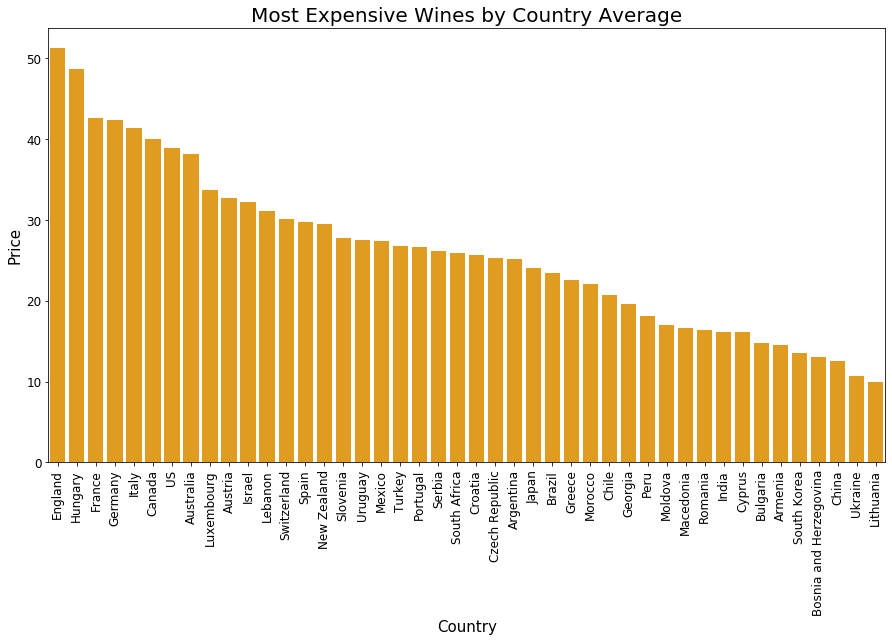

In [18]:
import seaborn as sns

s = sns.barplot(x='country', y='price', data=countriesGrouped, color='orange')

s.set_title("Most Expensive Wines by Country Average", fontsize=20)
s.set_xlabel("Country", fontsize=15)
s.set_ylabel("Price", fontsize=15)
s.set_xticklabels(s.get_xticklabels(), rotation=90)

plt.show()

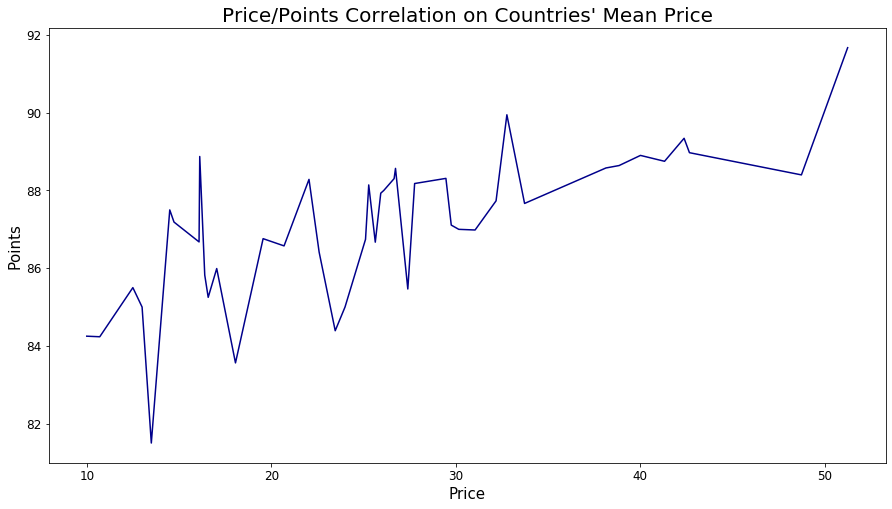

In [19]:
s = sns.lineplot(x='price', y='points', data=countriesGrouped, color='darkblue')

s.set_title("Price/Points Correlation on Countries' Mean Price", fontsize=20)
s.set_xlabel("Price", fontsize=15)
s.set_ylabel("Points", fontsize=15)

plt.show()

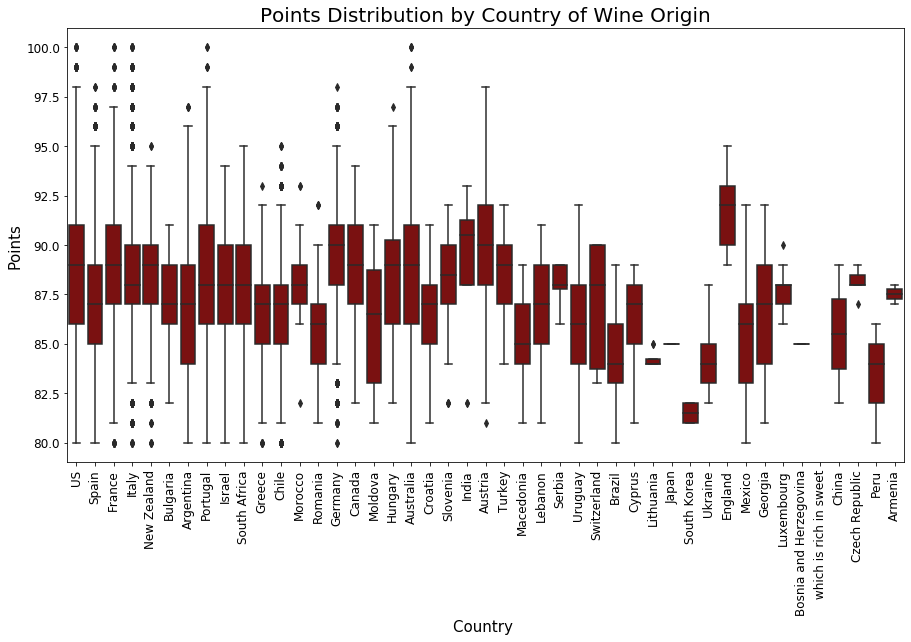

In [20]:
s = sns.boxplot(x='country', y='points', data=dataframe, color='darkred')

s.set_title("Points Distribution by Country of Wine Origin", fontsize=20)
s.set_xlabel("Country ", fontsize=15)
s.set_ylabel("Points", fontsize=15)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

plt.show()

In [21]:
provincesGrouped = dataframe.groupby(['province']).agg(['mean']).drop(columns=['id']).iloc[25:].reset_index()

provincesGrouped.columns = ['province', 'points', 'price']
provincesGrouped = provincesGrouped.sort_values(by=['price'], ascending=False).reset_index().drop(columns=['index'])

bestProvinces = provincesGrouped.head(10)['province']
provincesGrouped.head(10)

,province,points,price
0,Colares,90.666664,201.333328
1,Olifants River,90.000000,100.000000
2,Champagne,90.355606,85.616852
3,Santa Cruz,91.900002,85.000000
4,Moscatel do Douro,89.750000,84.375000
5,Leithaberg,93.250000,82.750000
6,Buin,90.928574,75.357140
7,Evia,87.000000,75.000000
8,Nevada,84.000000,75.000000
9,Rheingau,90.081665,74.200310


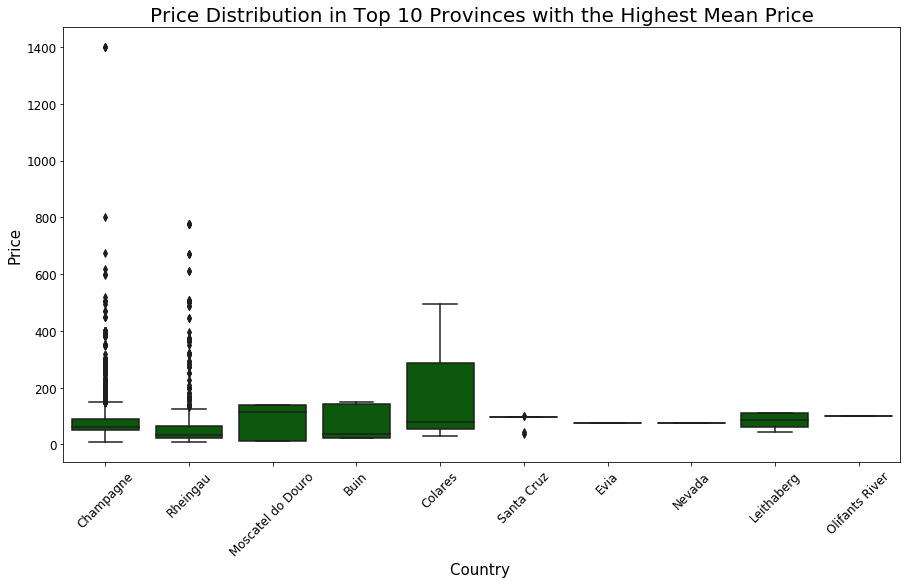

In [22]:
s = sns.boxplot(x='province', y='price', data=dataframe.loc[dataframe['province'].isin(bestProvinces)], color='darkgreen')

s.set_title("Price Distribution in Top 10 Provinces with the Highest Mean Price", fontsize=20)
s.set_xlabel("Country ", fontsize=15)
s.set_ylabel("Price", fontsize=15)
s.set_xticklabels(s.get_xticklabels(),rotation=45)

plt.show()

In [23]:
varietiesGrouped = dataframe.groupby(['variety']).count().iloc[11:].rename(columns={'id' : 'count'})
varietiesGrouped = varietiesGrouped.sort_values(by=['count'], ascending=False).reset_index() \
    .drop(columns=['country', 'description', 'designation', 'points', 'price', 'province', 'winery'])

varietiesGrouped.head()

,variety,count
0,Pinot Noir,19207
1,Chardonnay,16288
2,Red Blend,15341
3,Cabernet Sauvignon,13216
4,Riesling,8378


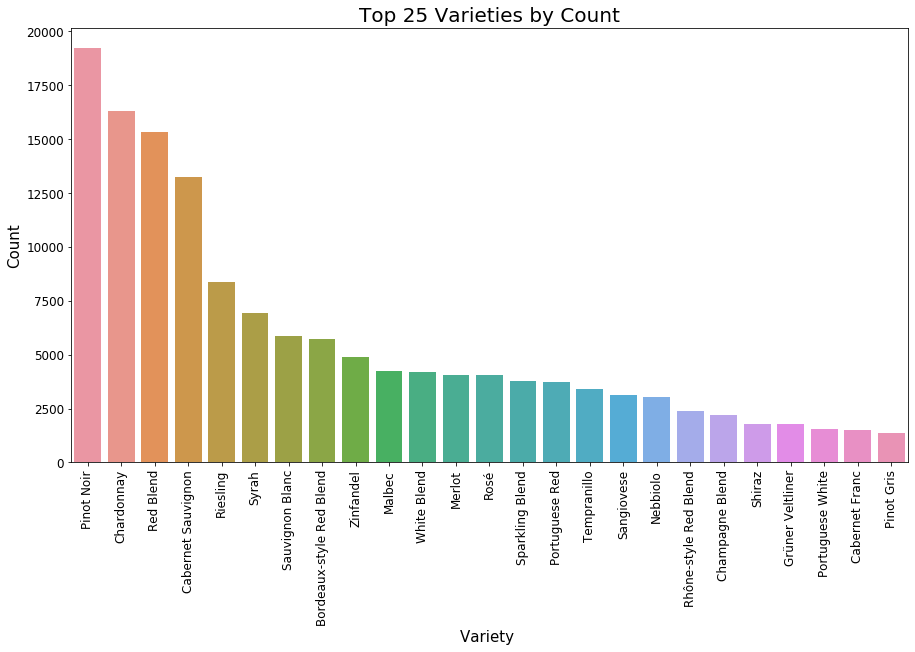

In [24]:
s = sns.barplot(x='variety', y='count', data=varietiesGrouped.head(25))

s.set_title("Top 25 Varieties by Count", fontsize=20)
s.set_xlabel("Variety ", fontsize=15)
s.set_ylabel("Count", fontsize=15)
s.set_xticklabels(s.get_xticklabels(), rotation=90)

plt.show()